In [1]:
! nvidia-smi

Sat Aug  8 15:55:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 31kB/s 
     |████████████████████████████████| 6.5MB 4.9MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [5]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/ThumbnailData.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 1.57 s, sys: 911 ms, total: 2.48 s
Wall time: 6.71 s


In [6]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [7]:
class_list       = [0,1,2,3]
class_names_dict = {0:'FB', 1:'LQ', 2:'SQ', 3:'WD'}
class_names      = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']

In [8]:
dataset          = prepare_data('/content/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*0.7)},Test Data length: {int(len(dataset)*0.3)}')
train_len = int(len(dataset)*0.7)

Dataset Length:19318, Train Data length: 13522,Test Data length: 5795


In [9]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 385 (delta 0), reused 0 (delta 0), pack-reused 379
Receiving objects: 100% (385/385), 16.33 MiB | 37.66 MiB/s, done.
Resolving deltas: 100% (195/195), done.


In [10]:
%cd '/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda'
! ls

/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda
EVA4P2_S2_MobilenetV2_V1.ipynb	EVA4P2_S2_zip_file_creation.ipynb
EVA4P2_S2_MobilenetV2_V2.ipynb	README.md
EVA4P2_S2_MobilenetV2_V3.ipynb	src
EVA4P2_S2_MobilenetV2_V4.ipynb	Understanding_1.txt
EVA4P2_S2_MobilenetV2_V6.ipynb	Weights


In [11]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.losses  import Train_Losses
from src.losses  import Test_Losses

In [12]:
import albumentations as A
channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = Alb.Albumentations_transform([
                                      A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      A.Resize(224, 224),
                                      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=56, max_w_size=56), # fillvalue is 0 after normalizing as mean is 0
                                    ])

#fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = Alb.Albumentations_transform([A.Resize(224, 224),
                                                A.Normalize(mean=channel_means, std=channel_stdevs),])

In [13]:
train = cds.Customdataset(dataset[:train_len],train_transforms)
test  = cds.Customdataset(dataset[train_len:],test_transforms)
print(f'Train Length {len(train)}, Test Length {len(test)}')

Train Length 13522, Test Length 5796


In [14]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, pin_memory = True)
test_loader   = DataLoader(test, batch_size = 32, shuffle = True, pin_memory = True)

In [15]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  #print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [16]:
dataiter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


To check if images are coming out correctly as batches, images.shape: torch.Size([32, 3, 224, 224]), labels.shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


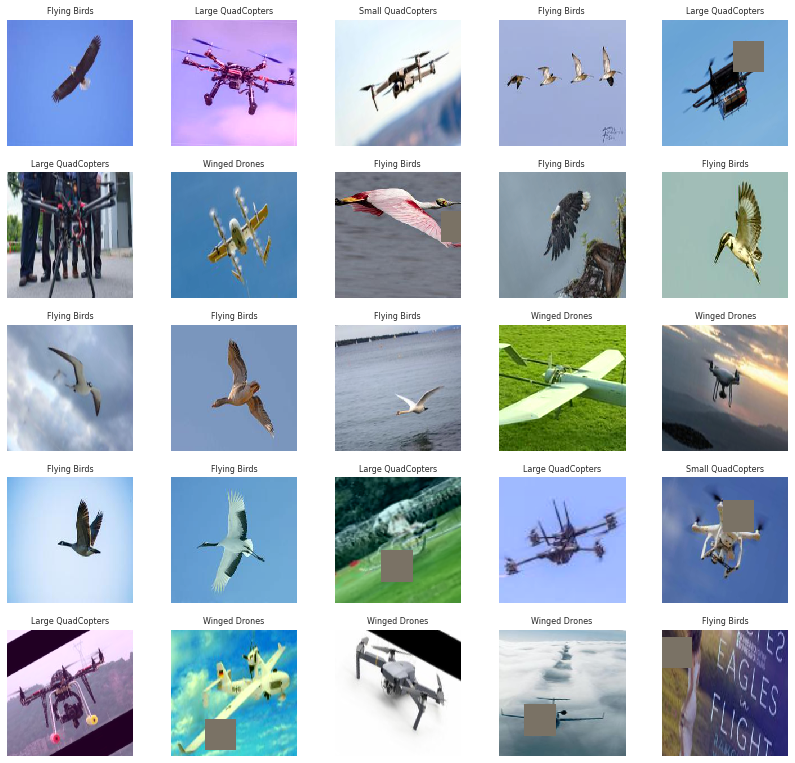

In [17]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show()    

### Downloading Pretrained Mobilenet_V2 and displaying summary to understand the layers & corresponding parms

In [18]:
!pip install torchsummary
from torchsummary import summary
model = torch.hub.load('pytorch/vision:v0.6.0','mobilenet_v2',pretrained=True)
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 224, 224))

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96

### Unfreezing only selected layers. Also customizing the FC layer to predict only 4 classes instead of 1000 classes (Mobilenet V2 is pretrained against imagenet which has 1000 classes)

In [19]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=4).to("cuda")
model.features[16].requires_grad  = True
model.features[17].requires_grad  = True
model.features[18].requires_grad  = True
model.classifier[0].requires_grad = True
model.classifier[1].requires_grad = True

### Displaying Layerwise view to understand convolutions, BN, Relu etc. coming under each layer. Will help us to reach a decision in which layer to unfreeze

In [20]:
model.to(model.device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [21]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_Losses.Test_loss()

### Displaying layer names against model. Will help us to customize/ unfreeze/ freeze selected layers

In [22]:
for name, module in model.named_modules():
    print('name:',name)

name: 
name: features
name: features.0
name: features.0.0
name: features.0.1
name: features.0.2
name: features.1
name: features.1.conv
name: features.1.conv.0
name: features.1.conv.0.0
name: features.1.conv.0.1
name: features.1.conv.0.2
name: features.1.conv.1
name: features.1.conv.2
name: features.2
name: features.2.conv
name: features.2.conv.0
name: features.2.conv.0.0
name: features.2.conv.0.1
name: features.2.conv.0.2
name: features.2.conv.1
name: features.2.conv.1.0
name: features.2.conv.1.1
name: features.2.conv.1.2
name: features.2.conv.2
name: features.2.conv.3
name: features.3
name: features.3.conv
name: features.3.conv.0
name: features.3.conv.0.0
name: features.3.conv.0.1
name: features.3.conv.0.2
name: features.3.conv.1
name: features.3.conv.1.0
name: features.3.conv.1.1
name: features.3.conv.1.2
name: features.3.conv.2
name: features.3.conv.3
name: features.4
name: features.4.conv
name: features.4.conv.0
name: features.4.conv.0.0
name: features.4.conv.0.1
name: features.4.c

#### Function to calculate class-wise accuracy

In [23]:
def calc_classwiseacc(total_cnt,correct_cnt):
    class_test_acc = []
    epsilon    = 1e-10                     # To avoid division by zero incase not a single image showed up for a particular class
    for i in range(len(class_list)):
        correct_class   =  total_class = 0
        correct_class   =  correct_cnt.get(class_list[i])
        total_class     =  total_cnt.get(class_list[i])
        total_class     += epsilon
        class_accuracy  =  round((correct_class/total_class *100), 2)
        class_test_acc.append(class_accuracy)
        print ('Test accuracy for class - ', class_list[i], ' - ', class_names_dict.get(class_list[i]), ' : ', class_accuracy, \
               'correct:',correct_class, 'Total:',int(total_class) )
    
    print('Total Test Images:',sum(total_cnt.values()),'Correct Images:',sum(correct_cnt.values()) )

    return class_test_acc

#### Command to load the model from saved GPU model weights from previous training.

In [24]:
#path = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0730V3.pt'
#model.load_state_dict(torch.load(path))
path_stable_prev_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_GPU_0808V1.pt'
model = torch.jit.load(path_stable_prev_save)

#### Train & Test for fixed epochs. Will save the model in 2 situations:
#### 1) When LR reduces based on ReduceLROnPlateau 
#### 2) On final Epoch. 
#### We are using 'torch.jit.save' instead of 'torch.save' as former is compatible with any of the mobile platforms - not just python (dynamically typed) can run even in platforms built in C which is statically typed programming languages

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 10
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.03

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []
prev_lr_value  = least_loss_lr

OPTIMIZER = optim.SGD(model.parameters(),lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min',factor=0.1, min_lr=1e-10, patience =4, verbose=True)
criterion = nn.CrossEntropyLoss()
path_stable_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_GPU_0808V1.pt'
path_final_save  = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Final_CPU_0808V1.pt'

for epoch in range(EPOCH):
  print('\nEPOCH:', epoch)
  train_losses, train_acc, lr_value = train_loss.train_loss_calc(model,model.device,train_loader=train_loader,optimizer=OPTIMIZER,
                                                       epoch=EPOCH, factor=L1_factor,criterion=criterion,
                                                       scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
  test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct, correct_predict, correct_pred_class, correct_act_class = \
                            test_loss.test_loss_calc(model,model.device,test_loader=test_loader,optimizer=OPTIMIZER,
                                                     total_epoch=EPOCH,current_epoch=epoch,criterion=criterion,
                                                     scheduler=SCHEDULER) 
  train_loss_all.extend(train_losses)
  train_acc_all.extend(train_acc)
  test_loss_all.extend(test_losses)
  test_acc_all.extend(test_acc)
  
  loss_decrease = 0  
  if len(test_loss_all) > 1:    
     loss_decrease = test_loss_all[-2] - test_loss_all[-1]
     if loss_decrease > 0:
        print(f'Test Loss -> Decreasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')
     else:
        print(f'Test Loss -> Increasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')

  if lr_value < prev_lr_value or epoch == int(EPOCH*0.8):           ### Keep the model in Gpu & Save the model values if loss values stabilized significantly
     script_module = torch.jit.script(model)      
     torch.jit.save(script_module, path_stable_save)
     print(f' **** Model Stable, hence Saved in epoch:{epoch} Prev Lr:{prev_lr_value} New Lr:{lr_value}:{path_stable_save}')  
  
  prev_lr_value = lr_value

  if epoch == (EPOCH -1):              ### Convert the model to CPU & save the model values on final epoch
     model.to('cpu')
     model.eval()
     traced_model = torch.jit.trace(model,torch.randn(1,3,224,224))      
     traced_model.save(path_final_save)    
     print(f' **** Model Saved in Final epoch:{epoch} Lr Value:{lr_value} :{path_final_save}')

     classwise_acc = calc_classwiseacc(label_total,label_correct)
     class_acc_all.append(classwise_acc)  

  0%|          | 0/423 [00:00<?, ?it/s]


EPOCH: 0


Train Loss = 1.900543451309204 Batch Id = 422 Train Acc = 71.17 LR =0.030000: 100%|██████████| 423/423 [00:58<00:00,  7.27it/s]
Train Loss = 1.8007798194885254 Batch Id = 0 Train Acc = 71.88 LR =0.030000:   0%|          | 1/423 [00:00<00:58,  7.23it/s]


Test set: Average loss: 0.0327, Test Accuracy: 77.64, LR : 0.030000

EPOCH: 1


Train Loss = 2.6623916625976562 Batch Id = 422 Train Acc = 72.59 LR =0.030000: 100%|██████████| 423/423 [00:57<00:00,  7.32it/s]
Train Loss = 2.689131259918213 Batch Id = 0 Train Acc = 59.38 LR =0.030000:   0%|          | 1/423 [00:00<00:56,  7.46it/s]


Test set: Average loss: 0.0375, Test Accuracy: 78.17, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.032680, Latest Loss:0.037527, Delta:-0.004847

EPOCH: 2


Train Loss = 1.7009422779083252 Batch Id = 422 Train Acc = 72.41 LR =0.030000: 100%|██████████| 423/423 [00:57<00:00,  7.39it/s]
Train Loss = 1.364613652229309 Batch Id = 0 Train Acc = 68.75 LR =0.030000:   0%|          | 1/423 [00:00<00:58,  7.27it/s]


Test set: Average loss: 0.0420, Test Accuracy: 77.67, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.037527, Latest Loss:0.042040, Delta:-0.004512

EPOCH: 3


Train Loss = 1.9670244455337524 Batch Id = 422 Train Acc = 72.13 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.44it/s]
Train Loss = 2.0209414958953857 Batch Id = 0 Train Acc = 75.00 LR =0.030000:   0%|          | 1/423 [00:00<00:56,  7.53it/s]


Test set: Average loss: 0.0453, Test Accuracy: 76.57, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.042040, Latest Loss:0.045347, Delta:-0.003308

EPOCH: 4


Train Loss = 1.7677959203720093 Batch Id = 422 Train Acc = 71.49 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.47it/s]
Train Loss = 0.9394789338111877 Batch Id = 0 Train Acc = 81.25 LR =0.030000:   0%|          | 1/423 [00:00<01:00,  6.93it/s]


Test set: Average loss: 0.0378, Test Accuracy: 79.83, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.045347, Latest Loss:0.037790, Delta:0.007558

EPOCH: 5


Train Loss = 2.295820951461792 Batch Id = 422 Train Acc = 72.33 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.50it/s]
Train Loss = 1.4255084991455078 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<00:54,  7.71it/s]

Epoch     6: reducing learning rate of group 0 to 3.0000e-03.

Test set: Average loss: 0.0366, Test Accuracy: 78.59, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.037790, Latest Loss:0.036592, Delta:0.001198

EPOCH: 6


Train Loss = 0.2664816379547119 Batch Id = 422 Train Acc = 75.20 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.52it/s]
Train Loss = 1.4526519775390625 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<01:00,  6.97it/s]


Test set: Average loss: 0.0250, Test Accuracy: 81.14, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.036592, Latest Loss:0.025012, Delta:0.011580
 **** Model Stable, hence Saved in epoch:6 Prev Lr:0.03 New Lr:0.003:/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_GPU_0808V1.pt

EPOCH: 7


Train Loss = 0.6613405346870422 Batch Id = 422 Train Acc = 75.89 LR =0.003000: 100%|██████████| 423/423 [00:57<00:00,  7.40it/s]
Train Loss = 0.8426195383071899 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.19it/s]


Test set: Average loss: 0.0214, Test Accuracy: 81.21, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.025012, Latest Loss:0.021426, Delta:0.003586

EPOCH: 8


Train Loss = 0.8955830931663513 Batch Id = 422 Train Acc = 75.24 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.48it/s]
Train Loss = 0.6273541450500488 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.09it/s]


Test set: Average loss: 0.0188, Test Accuracy: 82.37, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.021426, Latest Loss:0.018827, Delta:0.002599
 **** Model Stable, hence Saved in epoch:8 Prev Lr:0.003 New Lr:0.003:/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_GPU_0808V1.pt

EPOCH: 9


Train Loss = 1.4140963554382324 Batch Id = 422 Train Acc = 75.58 LR =0.003000: 100%|██████████| 423/423 [00:55<00:00,  7.56it/s]



Test set: Average loss: 0.0174, Test Accuracy: 82.44, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.018827, Latest Loss:0.017445, Delta:0.001382
 **** Model Saved in Final epoch:9 Lr Value:0.003 :/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Final_CPU_0808V1.pt
Test accuracy for class -  0  -  FB  :  97.88 correct: 2266 Total: 2315
Test accuracy for class -  1  -  LQ  :  67.81 correct: 754 Total: 1112
Test accuracy for class -  2  -  SQ  :  63.25 correct: 537 Total: 849
Test accuracy for class -  3  -  WD  :  80.33 correct: 1221 Total: 1520
Total Test Images: 5796 Correct Images: 4778


#### Gathering 10 misclassified images from each class and saving their index. These indexes will be referred later to display these misclassified images

In [104]:
disp_index   = []

for i in range(len(actual_class)):    
    if actual_class[i] == 0:
       disp_index.append(i)   
    elif len(disp_index) < 10:
       continue
    else:    
       print(f'Class 0 count: {len(disp_index)}')
       break

for i in range(len(actual_class)):    
    if actual_class[i] == 1:
       disp_index.append(i)
    elif len(disp_index) < 20:
       continue
    else:
       disp_index = disp_index[0:20]    
       print(f'Class 0+1 count: {len(disp_index)}')
       break    

for i in range(len(actual_class)):    
    if actual_class[i] == 2:
       disp_index.append(i)
    elif len(disp_index) < 30:
       continue
    else:    
       print(f'Class 0+1+2 count: {len(disp_index)}')
       break    

cnt = 0
for i in range(len(actual_class)):    
    if actual_class[i] == 3:
       disp_index.append(i)
       cnt += 1
    elif len(disp_index) < 40:
       continue
    else:    
       print(f'Class 0+1+2+3 count: {len(disp_index)}')
       break       

Class 0 count: 10
Class 0+1 count: 20
Class 0+1+2 count: 30
Class 0+1+2+3 count: 40


#### Plotting misclassified images received from last epoch. Will throw error message if misclassified images <25. In case of such an event adjust the subplots to suit the number of images to be plotted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

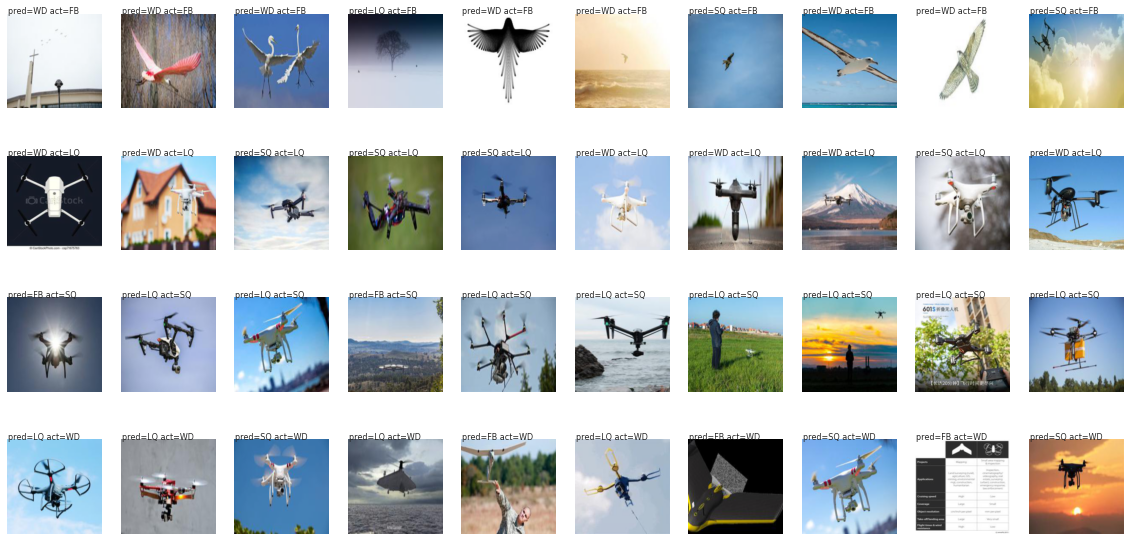

In [108]:
figure=plt.figure(figsize=(20,10))
for i in range(len(disp_index)):
    plt.subplot(4,10,i+1)
    plt.axis(False)
    j = disp_index[i]
    plt.imshow(unnormalize(wrong_predict[j].cpu()),interpolation='bilinear')
    prediction = class_names_dict.get(predicted_class[j])
    actual     = class_names_dict.get(actual_class[j])
    s="pred="+str(prediction)+" act="+str(actual)
    plt.text(2,-1,s,fontdict={'fontsize':8})

#### Plotting correctly classified images received from last epoch. Will throw error message if misclassified images <25. In case of such an event adjust the subplots to suit the number of images to be plotted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

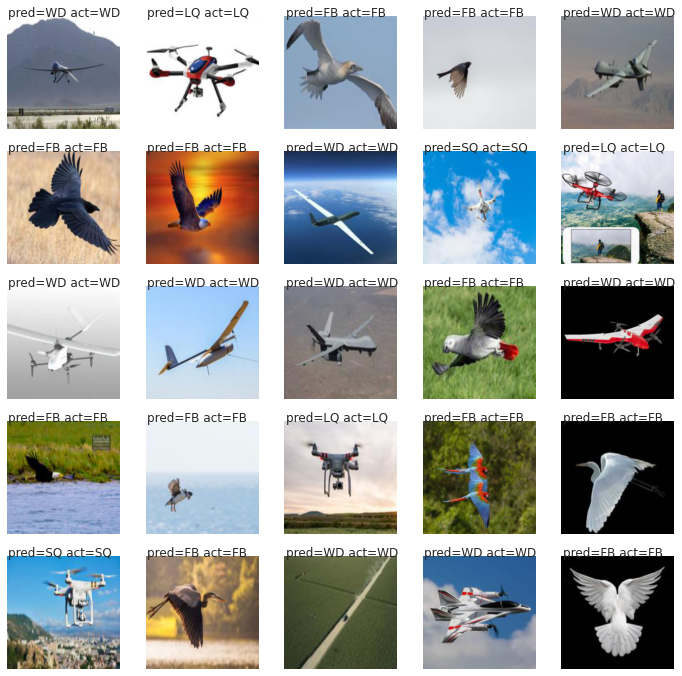

In [110]:
figure=plt.figure(figsize=(12,12))
if len(correct_pred_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      plt.imshow(unnormalize(correct_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(correct_pred_class[i])
      actual     = class_names_dict.get(correct_act_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Train & Test accuracies, Test Losses & Train Losses

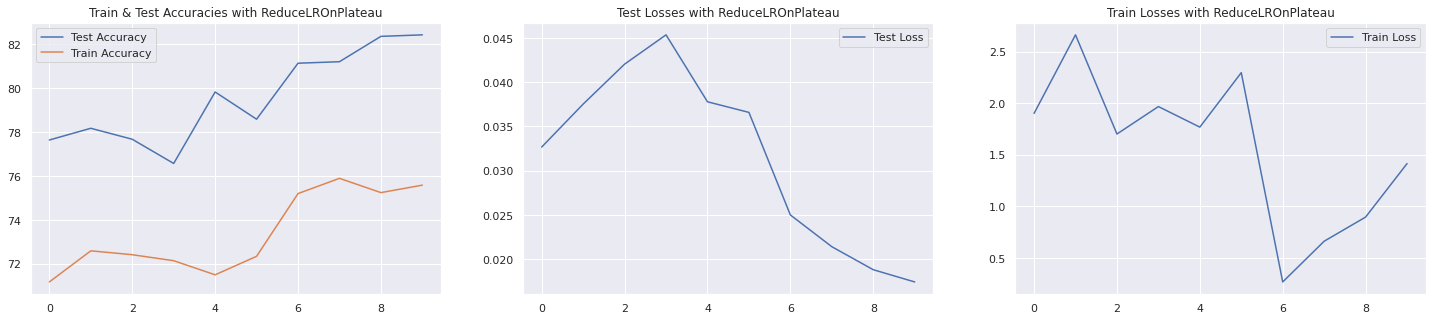

In [111]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")